<a href="https://colab.research.google.com/github/Hashara/CS4622-Machine-Learning-Project/blob/main/CS4622_Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libararies

In [1416]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1417]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OrdinalEncoder

# Read CSVs

In [1418]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1419]:
df_train_val = pd.read_csv('/content/drive/MyDrive/sem 7/ML - sem 7/Ml project/dataset/training_set_values.csv')
df_test_val = pd.read_csv('/content/drive/MyDrive/sem 7/ML - sem 7/Ml project/dataset/test_set_values.csv')
df_train_label = pd.read_csv('/content/drive/MyDrive/sem 7/ML - sem 7/Ml project/dataset/training_set_labels.csv')
df_submission = pd.read_csv('/content/drive/MyDrive/sem 7/ML - sem 7/Ml project/dataset/SubmissionFormat.csv')

In [1420]:
df_train_val

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [1421]:
df_train_label

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


# Feature engineering

## Missing Values

In [1422]:
cols_with_missing = [col for col in df_train_val.columns
                     if df_train_val[col].isnull().any()]

In [1423]:
cols_with_missing

['funder',
 'installer',
 'subvillage',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit']

## Fill missing values

### scheme_management

In [1424]:
df_train_val.scheme_management.describe()

count     55523
unique       12
top         VWC
freq      36793
Name: scheme_management, dtype: object

In [1425]:
df_train_val.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [1426]:
df_train_val.scheme_management = df_train_val.scheme_management.fillna('VWC')
df_test_val.scheme_management = df_test_val.scheme_management.fillna('VWC')

In [1427]:
df_train_val.loc[df_train_val.scheme_management == 'Trust', 'scheme_management'] = 'Other'
df_test_val.loc[df_test_val.scheme_management == 'Trust', 'scheme_management'] = 'Other'

df_train_val.loc[df_train_val.scheme_management == 'SWC', 'scheme_management'] = 'Other'
df_test_val.loc[df_test_val.scheme_management == 'SWC', 'scheme_management'] = 'Other'

### permit

In [1428]:
df_train_val.permit.describe()

count     56344
unique        2
top        True
freq      38852
Name: permit, dtype: object

In [1429]:
df_train_val.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [1430]:
df_train_val.permit = df_train_val.permit.fillna(True)
df_test_val.permit = df_test_val.permit.fillna(True)

### public_meeting

In [1431]:
# df_train_val.public_meeting.describe()

In [1432]:
# df_train_val.public_meeting.value_counts()

In [1433]:
# df_train_val.public_meeting = df_train_val.permit.fillna(False)
# df_test_val.public_meeting = df_test_val.permit.fillna(False)

### installer

In [1434]:
df_train_val.installer.describe()

count     55745
unique     2145
top         DWE
freq      17402
Name: installer, dtype: object

In [1435]:
df_train_val.installer.value_counts()

DWE                               17402
Government                         1825
RWE                                1206
Commu                              1060
DANIDA                             1050
                                  ...  
Governmen                             1
Building works engineering Ltd        1
Obadia                                1
Kanisani                              1
Omari Mzee                            1
Name: installer, Length: 2145, dtype: int64

In [1436]:
df_test_val.loc[df_train_val.groupby('installer').installer.transform('count').lt(50), 'installer'] = "Other" 
df_test_val.loc[df_test_val.groupby('installer').installer.transform('count').lt(50), 'installer'] = "Other"
df_train_val.loc[df_train_val.groupby('installer').installer.transform('count').lt(50), 'installer'] = "Other"    

In [1437]:
df_train_val.installer = df_train_val.installer.fillna('DWE')
df_test_val.installer = df_test_val.installer.fillna('DWE')

## Drop missing values

In [1438]:
cols_with_missing = [col for col in df_test_val.columns
                     if df_test_val[col].isnull().any()]
cols_with_missing

['funder', 'subvillage', 'public_meeting', 'scheme_name']

In [1439]:
# drop missing values
df_train_val = df_train_val.drop(columns = cols_with_missing)
df_test_val = df_test_val.drop(columns = cols_with_missing)

## Exploring data

In [1440]:
df_train_val.columns

Index(['id', 'amount_tsh', 'date_recorded', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [1441]:
df_train_val.head()

,id,amount_tsh,date_recorded,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,lga,ward,population,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,109,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,1399,Other,34.698766,-2.147466,Zahanati,0,Lake Victoria,Mara,20,2,Serengeti,Natta,280,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Manyara,21,4,Simanjiro,Ngorika,250,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,Nanyumbu,58,GeoData Consultants Ltd,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kagera,18,1,Karagwe,Nyakasimbi,0,GeoData Consultants Ltd,VWC,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [1442]:
df_train_val.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [1443]:
df_train_val.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,permit,construction_year
id,1.000000,-0.005321,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.000070,-0.002082
amount_tsh,-0.005321,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.023026,0.067915
gps_height,-0.004692,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.091959,0.658727
longitude,-0.001348,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.103182,0.396732
latitude,0.001718,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,0.070615,-0.245278
num_private,-0.002629,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.008602,0.026056
region_code,-0.003028,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,-0.036440,0.031724
district_code,-0.003044,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,-0.081400,0.048315
population,-0.002813,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,-0.036004,0.260910
permit,-0.000070,0.023026,0.091959,0.103182,0.070615,0.008602,-0.036440,-0.081400,-0.036004,1.000000,0.077197


## Adding new features

In [1444]:
df_train_val.head()

,id,amount_tsh,date_recorded,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,lga,ward,population,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,109,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,1399,Other,34.698766,-2.147466,Zahanati,0,Lake Victoria,Mara,20,2,Serengeti,Natta,280,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Manyara,21,4,Simanjiro,Ngorika,250,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,Nanyumbu,58,GeoData Consultants Ltd,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kagera,18,1,Karagwe,Nyakasimbi,0,GeoData Consultants Ltd,VWC,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Number of years

In [1445]:
df_train_val["year_recorded"] = df_train_val["date_recorded"].astype(str).str[0:4].astype(int)
df_test_val["year_recorded"] = df_test_val["date_recorded"].astype(str).str[0:4].astype(int)

In [1446]:
df_train_val["number_of_years"] = df_train_val["year_recorded"] - df_train_val["construction_year"]
df_test_val["number_of_years"] = df_test_val["year_recorded"] - df_test_val["construction_year"]

In [1447]:
df_train_val["number_of_years"].value_counts()

 2011    13343
 2012     5142
 3        2740
 1        2303
 2013     2210
         ...  
-1           1
-3           1
-2           1
 2002        1
-7           1
Name: number_of_years, Length: 65, dtype: int64

In [1448]:
x = pd.DataFrame()
x["number_of_years"] = df_train_val["number_of_years"]
x = x.drop(x[x.number_of_years > 2000].index)
x["number_of_years"].describe()

count    38691.000000
mean        15.355742
std         12.492673
min         -7.000000
25%          5.000000
50%         13.000000
75%         25.000000
max         53.000000
Name: number_of_years, dtype: float64

In [1449]:
df_train_val.loc[df_train_val.number_of_years > 2000, 'number_of_years'] = 15
df_test_val.loc[df_train_val.number_of_years > 2000, 'number_of_years'] = 15

In [1450]:
df_train_val.head()

,id,amount_tsh,date_recorded,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,lga,ward,population,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,number_of_years
0,69572,6000.0,2011-03-14,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,109,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2011,12
1,8776,0.0,2013-03-06,1399,Other,34.698766,-2.147466,Zahanati,0,Lake Victoria,Mara,20,2,Serengeti,Natta,280,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2013,3
2,34310,25.0,2013-02-25,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Manyara,21,4,Simanjiro,Ngorika,250,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2013,4
3,67743,0.0,2013-01-28,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,Nanyumbu,58,GeoData Consultants Ltd,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,2013,27
4,19728,0.0,2011-07-13,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kagera,18,1,Karagwe,Nyakasimbi,0,GeoData Consultants Ltd,VWC,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2011,15


In [1451]:
df_train_val["status_group"] = df_train_label["status_group"]

### GPS height

In [1452]:
df_train_val["gps_height"].describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

In [1453]:
df_train_val["gps_height"].value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a6d120250>]],
      dtype=object)

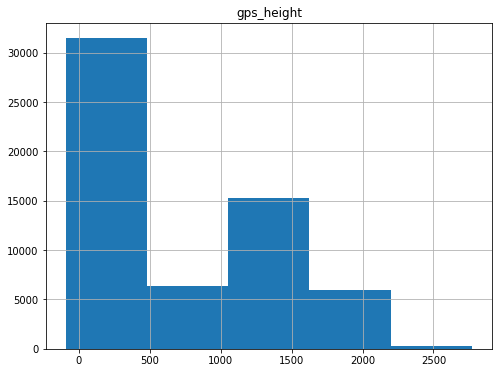

In [1454]:
df_train_val.hist(column=['gps_height'],bins=5, figsize=(8,6))

In [1455]:
# #group 
# category = pd.cut(df_train_val.gps_height,bins=[0,500,1000,1500,2000,2500,3000],labels=[0,1,2,3,4,5])
# df_train_val.insert(5,'gps_height_group',category)

# category = pd.cut(df_test_val.gps_height,bins=[0,500,1000,1500,2000,2500,3000],labels=[0,1,2,3,4,5])
# df_test_val.insert(5,'gps_height_group',category)

### Population

In [1456]:
df_train_val["population"].describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [1457]:
df_train_val["population"].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [1458]:
x = pd.DataFrame()
x["population"] = df_train_val["population"]
x = x.drop(x[x.population < 10].index)
x["population"].describe()

count    30873.000000
mean       345.898293
std        608.550210
min         10.000000
25%        100.000000
50%        200.000000
75%        380.000000
max      30500.000000
Name: population, dtype: float64

In [1459]:
x["population"].value_counts().sort_index()

10       163
11         7
12        43
13        12
14        18
        ... 
9865       1
10000      3
11463      1
15300      1
30500      1
Name: population, Length: 1039, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a6d656d50>]],
      dtype=object)

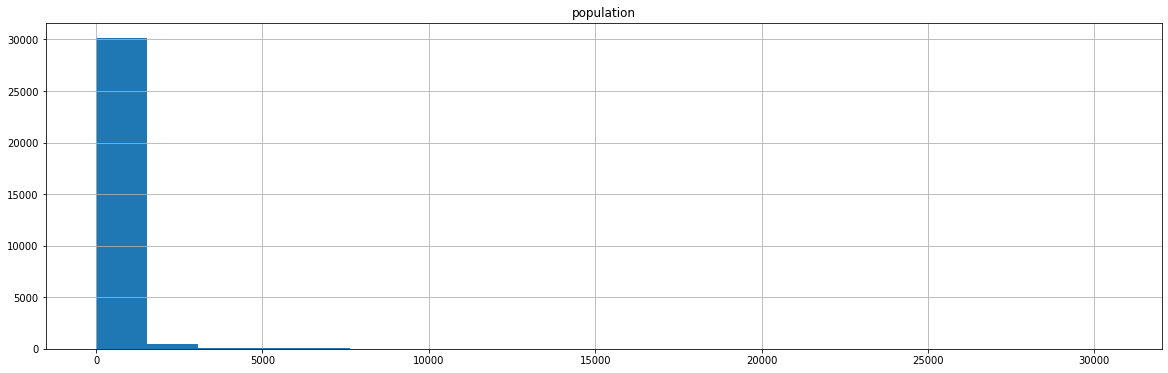

In [1460]:
x.hist(column=['population'],bins=20, figsize=(20,6))

In [1461]:
df_train_val.loc[df_train_val.number_of_years < 10, 'population'] = 346
df_test_val.loc[df_test_val.number_of_years < 10, 'population'] = 346

In [1462]:
[col for col in df_train_val.columns
                     if df_train_val[col].isnull().any()]

[]

In [1463]:
#group 
category = pd.cut(df_train_val.population,bins=[-100,250,500,1000,2500,5000,100000],labels=[0,1,2,3,4,5])
df_train_val.insert(6,'population_group',category)

category = pd.cut(df_test_val.population,bins=[-100,250,500,1000,2500,5000,100000],labels=[0,1,2,3,4,5])
df_test_val.insert(6,'population_group',category)

In [1464]:
[col for col in df_train_val.columns
                     if df_train_val[col].isnull().any()]

[]

In [1465]:
df_train_val.population.describe()

count    59400.000000
mean       198.154461
std        334.808843
min          0.000000
25%          0.000000
50%        100.000000
75%        346.000000
max      15300.000000
Name: population, dtype: float64

In [1466]:
df_train_val.population_group.value_counts()

0    35861
1    20755
2     1967
3      653
4      132
5       32
Name: population_group, dtype: int64

## Encoding

In [1467]:
# object_cols = [ 'basin', 'lga', 'ward','extraction_type','extraction_type_group',
#                'extraction_type_class','management', 'management_group', 'payment',	'payment_type',
#                'water_quality',	'quality_group',	'quantity',	'quantity_group',	'source',	'source_type',
#                'source_class',	'waterpoint_type',	'waterpoint_type_group']
object_cols = ['payment_type', 'source_type', 'quantity_group','quality_group', 'management', 
               'extraction_type_group', 'recorded_by', 'population_group','scheme_management', 'installer']
# , 'basin', 'lga', 'ward','extraction_type','extraction_type_group',
#                'extraction_type_class','management', 'management_group', 'payment',	'payment_type',
#                'water_quality',	'quality_group',	'quantity',	'quantity_group',	'source',	'source_type',
#                'source_class',	'waterpoint_type',	'waterpoint_type_group']

In [1468]:
label_X_train = df_train_val.copy()
label_X_test = df_test_val.copy()
# df_train_val = label_X_train.copy()
# df_test_val = label_X_test.copy()

In [1469]:
# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
df_train_val[object_cols] = ordinal_encoder.fit_transform(df_train_val[object_cols])
df_test_val[object_cols] = ordinal_encoder.transform(df_test_val[object_cols])

In [1470]:
df_train_val[object_cols].head()

,payment_type,source_type,quantity_group,quality_group,management,extraction_type_group,recorded_by,population_group,scheme_management,installer
0,0.0,6.0,1.0,2.0,7.0,1.0,0.0,0.0,5.0,111.0
1,2.0,3.0,2.0,2.0,11.0,1.0,0.0,1.0,2.0,98.0
2,5.0,1.0,1.0,2.0,7.0,1.0,0.0,1.0,5.0,142.0
3,2.0,0.0,0.0,2.0,7.0,10.0,0.0,0.0,5.0,124.0
4,2.0,3.0,3.0,2.0,1.0,1.0,0.0,0.0,5.0,10.0


In [1471]:
df_train_val[object_cols].corr()

,payment_type,source_type,quantity_group,quality_group,management,extraction_type_group,recorded_by,population_group,scheme_management,installer
payment_type,1.000000,-0.173454,0.006905,0.167419,0.047778,0.151146,NaN,0.023303,-0.003167,0.014189
source_type,-0.173454,1.000000,-0.000585,-0.188973,0.085285,-0.367032,NaN,-0.090608,0.022355,-0.114597
quantity_group,0.006905,-0.000585,1.000000,0.011646,-0.071967,-0.011712,NaN,0.041145,-0.055105,0.035358
quality_group,0.167419,-0.188973,0.011646,1.000000,-0.017531,0.157439,NaN,0.007282,-0.035683,-0.006079
management,0.047778,0.085285,-0.071967,-0.017531,1.000000,0.019687,NaN,-0.081188,0.617678,-0.043580
extraction_type_group,0.151146,-0.367032,-0.011712,0.157439,0.019687,1.000000,NaN,0.050742,-0.034987,0.060717
recorded_by,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population_group,0.023303,-0.090608,0.041145,0.007282,-0.081188,0.050742,NaN,1.000000,0.024989,0.104157
scheme_management,-0.003167,0.022355,-0.055105,-0.035683,0.617678,-0.034987,NaN,0.024989,1.000000,0.027196
installer,0.014189,-0.114597,0.035358,-0.006079,-0.043580,0.060717,NaN,0.104157,0.027196,1.000000


## Ploting data

In [1472]:
plt.figure(figsize=(20,20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

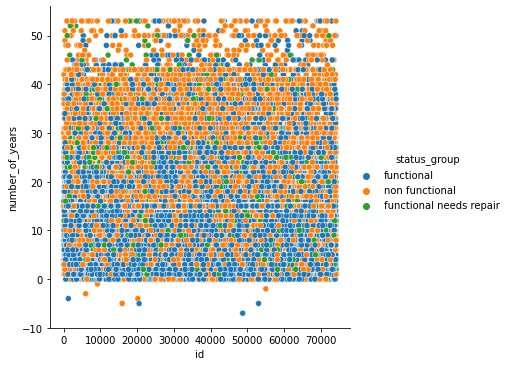

In [1473]:
sns.relplot(x="id",y="number_of_years",hue="status_group",data=df_train_val);

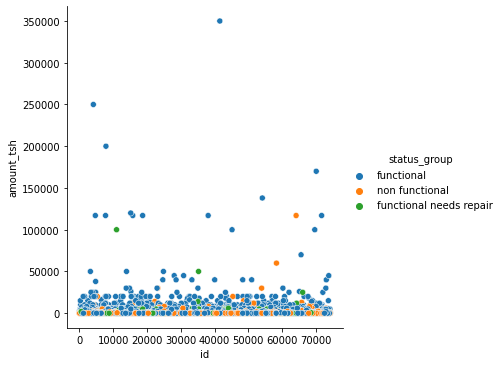

In [1474]:
sns.relplot(x="id",y="amount_tsh",hue="status_group",data=df_train_val);

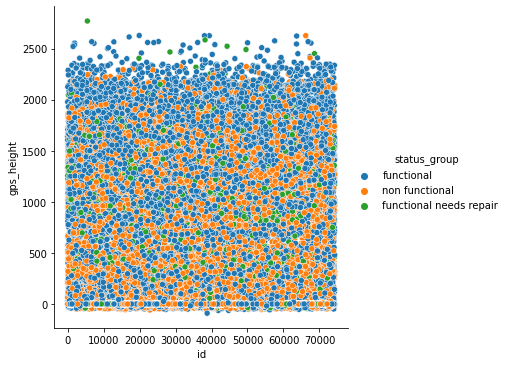

In [1475]:
sns.relplot(x="id",y="gps_height",hue="status_group",data=df_train_val);

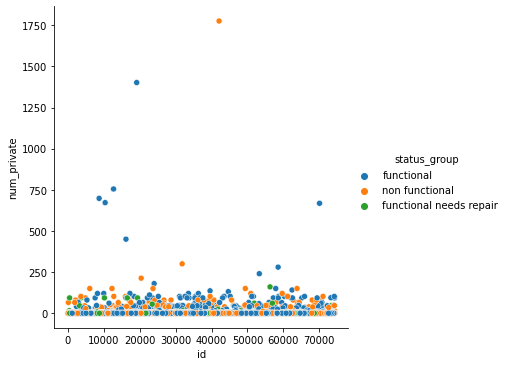

In [1476]:
sns.relplot(x="id",y="num_private",hue="status_group",data=df_train_val);

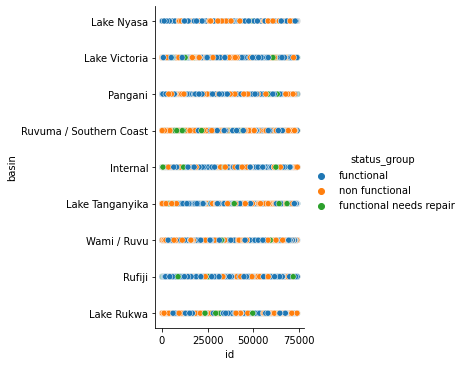

In [1477]:
sns.relplot(x="id",y="basin",hue="status_group",data=df_train_val);

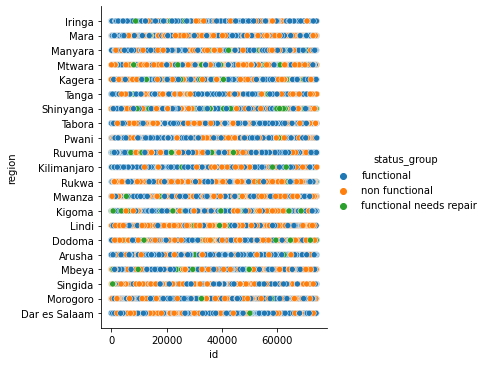

In [1478]:
sns.relplot(x="id",y="region",hue="status_group",data=df_train_val);

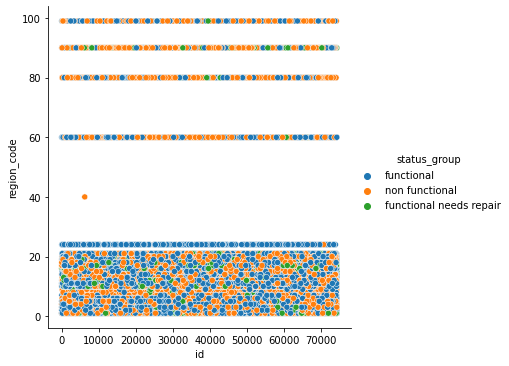

In [1479]:
sns.relplot(x="id",y="region_code",hue="status_group",data=df_train_val);

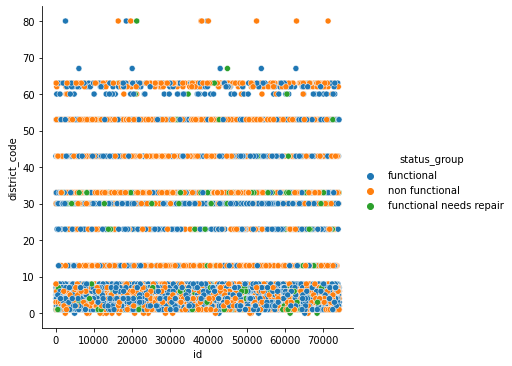

In [1480]:
sns.relplot(x="id",y="district_code",hue="status_group",data=df_train_val);

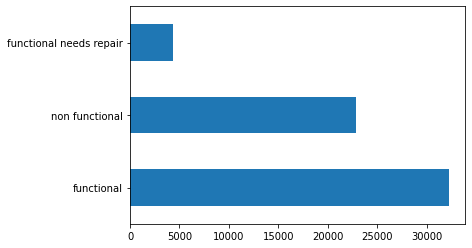

In [1481]:
df_train_val.status_group.value_counts().plot.barh()

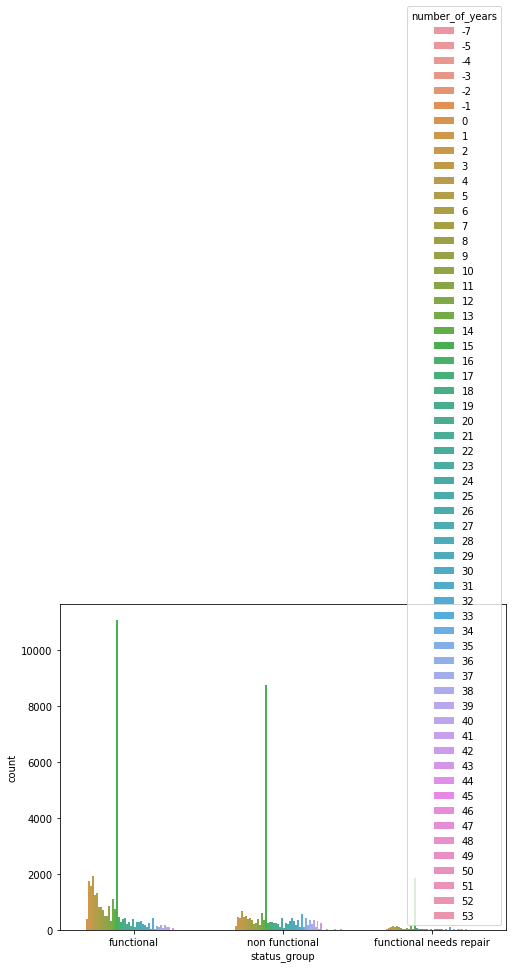

In [1482]:
plt.figure(figsize=(8,6))
sns.countplot(x='status_group', hue='number_of_years', data= df_train_val)

# Clean dataset

In [1483]:
df_train_val.columns

Index(['id', 'amount_tsh', 'date_recorded', 'gps_height', 'installer',
       'longitude', 'population_group', 'latitude', 'wpt_name', 'num_private',
       'basin', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'recorded_by', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'year_recorded',
       'number_of_years', 'status_group'],
      dtype='object')

In [1485]:
df_train_clean = df_train_val.drop(columns=['id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude',
       'latitude', 'wpt_name', 'basin', 'region', 
       'lga', 'ward',  'recorded_by', 'population',
       'construction_year', 'extraction_type', 'installer',
       'extraction_type_class',  'management_group', 'payment',
       'water_quality',  'quantity', 'scheme_management',
       'source', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'year_recorded',
       'status_group'])
df_test_clean = df_test_val.drop(columns=['id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude',
       'latitude', 'wpt_name',  'basin', 'region', 
       'lga', 'ward',  'recorded_by', 'population',
       'construction_year', 'extraction_type', 'installer',
       'extraction_type_class', 'management_group', 'payment',
       'water_quality', 'quantity', 'scheme_management',
        'source',  'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'year_recorded'])
df_train_label_clean = df_train_val["status_group"]

# ['funder',
#  'installer',
#  'subvillage',
#  'scheme_management',
#  'scheme_name',
#  'permit']

In [1486]:
df_test_clean.head()

,population_group,num_private,region_code,district_code,permit,extraction_type_group,management,payment_type,quality_group,quantity_group,source_type,number_of_years
0,1.0,0,21,3,True,6.0,3.0,2.0,2.0,3.0,3.0,1
1,1.0,0,2,2,True,1.0,7.0,2.0,2.0,2.0,6.0,13
2,1.0,0,13,2,True,6.0,7.0,2.0,2.0,2.0,3.0,3
3,0.0,0,80,43,True,6.0,7.0,6.0,2.0,0.0,5.0,26
4,0.0,0,10,3,True,1.0,9.0,1.0,2.0,1.0,6.0,13


In [1487]:
X_train, X_test, y_train, y_test = train_test_split(df_train_clean, df_train_label_clean, test_size=0.2, random_state=10, shuffle=True)

# Model

## Random forest

In [1488]:
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rfc_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [1489]:
predictions = rfc_model.predict(X_test)

In [1490]:
logreg_score_train = rfc_model.score(X_train,y_train)
print("Train Prediction Score",logreg_score_train*100)
logreg_score_test = accuracy_score(y_test,predictions)
print("Test Prediction ",logreg_score_test*100)

Train Prediction Score 70.94065656565657
Test Prediction  70.61447811447812


## XgBoost

In [1491]:
xgb_model = XGBClassifier(max_depth=3,n_estimators=100,learning_rate=0.12,random_state=10)
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.12, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [1492]:
predictions = xgb_model.predict(X_test)

In [1493]:
logreg_score_train = xgb_model.score(X_train,y_train)
print("Train Prediction Score",logreg_score_train*100)
logreg_score_test = accuracy_score(y_test,predictions)
print("Test Prediction ",logreg_score_test*100)

Train Prediction Score 73.17550505050505
Test Prediction  72.95454545454545


## DT

In [1494]:
dt = DecisionTreeClassifier( max_leaf_nodes=600)
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=600,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [1495]:
predictions = dt.predict(X_test)

In [1496]:
logreg_score_train = dt.score(X_train,y_train)
print("Train Prediction Score",logreg_score_train*100)
logreg_score_test = accuracy_score(y_test,predictions)
print("Test Prediction ",logreg_score_test*100)

Train Prediction Score 78.41329966329967
Test Prediction  75.83333333333333


## Naive Bayes

In [1497]:
naive = GaussianNB()
naive.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [1498]:
predictions = naive.predict(X_test)

In [1499]:
logreg_score_train = naive.score(X_train,y_train)
print("Train Prediction Score",logreg_score_train*100)
logreg_score_test = accuracy_score(y_test,predictions)
print("Test Prediction ",logreg_score_test*100)

Train Prediction Score 57.56313131313131
Test Prediction  57.60942760942761


## Gradient Boosting

In [1500]:
gd = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0)
gd.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [1501]:
predictions = gd.predict(X_test)

In [1502]:
logreg_score_train = gd.score(X_train,y_train)
print("Train Prediction Score",logreg_score_train*100)
logreg_score_test = accuracy_score(y_test,predictions)
print("Test Prediction ",logreg_score_test*100)

Train Prediction Score 76.64983164983164
Test Prediction  75.23569023569023


# Write to CSV

In [1503]:
df_submission["status_group"] = naive.predict(df_test_clean)

In [1504]:
# df_submission["status_group"].replace({"predicted label": "functional"}, inplace=True)

In [1505]:
df_submission.to_csv("gd.csv", index= False)